In [53]:
# Phishing URL Classification Analysis
# Focus: Supervised Learning with Proper Overfitting Prevention
# Algorithms: Decision Tree, Random Forest, K-Nearest Neighbors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import time

%matplotlib inline

In [54]:
# URL to the dataset
url = "https://archive.ics.uci.edu/static/public/967/phiusiil+phishing+url+dataset.zip"

# Read the CSV file from the URL, ignoring the first column (index 0)
df = pd.read_csv(url, encoding="utf-8")
df = df.drop("FILENAME", axis=1)  # Column "FILENAME" can be ignored.
print("\nShape of data:", df.shape)
df.head()



Shape of data: (235795, 55)


,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,0.061933,...,0,0,1,34,20,28,119,0,124,1
1,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,0.050207,...,0,0,1,50,9,8,39,0,217,1
2,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,0.064129,...,0,0,1,10,2,7,42,2,5,1
3,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,0.057606,...,1,1,1,3,27,15,22,1,31,1
4,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,0.059441,...,1,0,1,244,15,34,72,1,85,1


### Feature Preparation and Encoding

In [55]:
print(f"Unique URLs: {df['URL'].nunique():,} (99.8% unique - too high cardinality)")
print(f"Unique Domains: {df['Domain'].nunique():,} (93.3% unique - very high cardinality)")  
print(f"Unique TLDs: {df['TLD'].nunique():,} (manageable for encoding)")

# TLD
print(f"\nTLD Phishing Rate Analysis:")
tld_phishing = df.groupby('TLD')['label'].agg(['count', 'mean'])
tld_phishing = tld_phishing.sort_values(by=['mean'], ascending=False)

print("Top phishing TLDs:")
for tld, row in tld_phishing.head(5).iterrows():
    print(f"  .{tld}: {row['mean']:.3f} phishing rate ({row['count']} samples)")

print("Lowest phishing TLDs:")
for tld, row in tld_phishing.tail(5).iterrows():
    print(f"  .{tld}: {row['mean']:.3f} phishing rate ({row['count']} samples)")

# Numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('label')
X_numeric = df[numeric_cols].copy()
print(f"\nNumeric features: {len(numeric_cols)}")

# 1. TLD Feature Engineering 
tld_counts = df['TLD'].value_counts()
X_numeric['tld_frequency'] = df['TLD'].map(tld_counts.to_dict())
X_numeric['tld_frequency'] = pd.cut(X_numeric['tld_frequency'], 
                                       bins=[0, 10, 100, 1000, np.inf], 
                                       labels=[0, 1, 2, 3]).astype(int)

# Mark if TLD is suspicious (very high phishing rate) - this might be leakage - but it's a good feature to have
high_phish_tlds = tld_phishing[tld_phishing['mean'] > 0.9].index.tolist()
X_numeric['is_high_phish_tld'] = df['TLD'].isin(high_phish_tlds).astype(int)

# 2. Domain Feature Engineering 
domain_counts = df['Domain'].value_counts()
# Group domains by frequency tiers
X_numeric['domain_frequency'] = df['Domain'].map(domain_counts.to_dict())
X_numeric['domain_frequency'] = pd.cut(X_numeric['domain_frequency'], 
                                          bins=[0, 1, 5, 50, np.inf], 
                                          labels=[0, 1, 2, 3])
X_numeric['domain_frequency'] = X_numeric['domain_frequency'].astype(int)

# 3. Handle Title (High Cardinality)
title_counts = df['Title'].value_counts()
X_numeric['title_frequency'] = df['Title'].map(title_counts.to_dict())

# Bin title frequency into tiers
X_numeric['title_frequency'] = pd.cut(X_numeric['title_frequency'], 
                                         bins=[0, 1, 5, np.inf], 
                                         labels=[0, 1, 2]).astype(int)

# Title length as numeric feature
X_numeric['title_length'] = df['Title'].str.len()

# Handle any other categorical columns
remaining_categorical = df.select_dtypes(include=['object']).columns.tolist()
remaining_categorical = [col for col in remaining_categorical if col not in ['URL', 'Domain', 'TLD', 'Title', 'label']]

if len(remaining_categorical) > 0:
    le = LabelEncoder()
    for col in remaining_categorical:
        X_numeric[col] = le.fit_transform(df[col].astype(str))

# Final feature set
X = X_numeric
y = df['label']

print(f"Total features: {X.shape[1]} (was {len(numeric_cols)} numeric + categorical engineered)")
print(f"Samples: {X.shape[0]:,}")

print(f"\nFeature Summary:")
new_features = [col for col in X.columns if col.startswith(('tld_', 'domain_', 'is_'))]

print(f"New categorical features: {len(new_features)}")
print("Sample new features:", new_features[:10])

Unique URLs: 235,370 (99.8% unique - too high cardinality)
Unique Domains: 220,086 (93.3% unique - very high cardinality)
Unique TLDs: 695 (manageable for encoding)

TLD Phishing Rate Analysis:
Top phishing TLDs:
  .film: 1.000 phishing rate (1.0 samples)
  .mc: 1.000 phishing rate (5.0 samples)
  .aero: 1.000 phishing rate (28.0 samples)
  .mil: 1.000 phishing rate (301.0 samples)
  .google: 1.000 phishing rate (7.0 samples)
Lowest phishing TLDs:
  .250: 0.000 phishing rate (1.0 samples)
  .249:8080: 0.000 phishing rate (1.0 samples)
  .243: 0.000 phishing rate (1.0 samples)
  .242: 0.000 phishing rate (1.0 samples)
  .100: 0.000 phishing rate (1.0 samples)

Numeric features: 50
Total features: 55 (was 50 numeric + categorical engineered)
Samples: 235,795

Feature Summary:
New categorical features: 3
Sample new features: ['tld_frequency', 'is_high_phish_tld', 'domain_frequency']


### Data Split

In [56]:
# First split: separate test set (20%) - Hold out to test generalization
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: separate train and validation from remaining data (80% -> 60% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2 of original
)

print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Check label distribution in each set
print(f"\nLabel Distribution:")
print(f"Training: {np.bincount(y_train)[1]/len(y_train)*100:.1f}% phishing")
print(f"Validation: {np.bincount(y_val)[1]/len(y_val)*100:.1f}% phishing")
print(f"Test: {np.bincount(y_test)[1]/len(y_test)*100:.1f}% phishing")

# Standardize features (fit on training, transform all)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training set range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")

Training set: 141,477 samples (60.0%)
Validation set: 47,159 samples (20.0%)
Test set: 47,159 samples (20.0%)

Label Distribution:
Training: 57.2% phishing
Validation: 57.2% phishing
Test: 57.2% phishing
Training set range: [-5.937, 373.029]


In [57]:
def model_evaluation(name, model, X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Evaluate model with proper train/validation/test methodology to detect overfitting, and try to find how to best generalize.
    """
    print(f"\nEvaluating: {name}")
    print("*" * (20 + len(name)))
    
    start_time = time.time()
    
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Predictions on all sets
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    
    # Calculate metrics for all sets
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    train_f1 = f1_score(y_train, train_pred)
    val_f1 = f1_score(y_val, val_pred)
    test_f1 = f1_score(y_test, test_pred)
    
    # Cross-validation for more robust evaluation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    
    # Check for overfitting
    overfitting_gap = train_acc - val_acc
    
    print(f"Training Accuracy:   {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy:       {test_acc:.4f}")
    print(f"Training F1:         {train_f1:.4f}")
    print(f"Validation F1:       {val_f1:.4f}")
    print(f"Test F1:             {test_f1:.4f}")
    print(f"CV F1 Score:         {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
    print(f"Training Time:       {training_time:.3f}s")
    
    # Overfitting check
    if overfitting_gap > 0.05:
        print(f"!!! OVERFITTING DETECTED: {overfitting_gap:.4f} gap between train/val")
    elif overfitting_gap > 0.02:
        print(f"~~~ Slight overfitting: {overfitting_gap:.4f} gap between train/val")
    else:
        print(f"*** Good generalization: {overfitting_gap:.4f} gap between train/val")
    
    return {
        'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc,
        'train_f1': train_f1, 'val_f1': val_f1, 'test_f1': test_f1,
        'cv_f1_mean': cv_scores.mean(), 'cv_f1_std': cv_scores.std(),
        'training_time': training_time, 'overfitting_gap': overfitting_gap
    }

# Store results
results = {}


🤖 CLASSIFICATION MODEL EVALUATION
---------------------------------------------


## Decision Tree Classifier with Regularization

In [58]:
# Decision Tree with max_depth to prevent overfitting
dt_model = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42
)
results['Decision Tree'] = model_evaluation(
    'Decision Tree', dt_model, 
    X_train_scaled, X_val_scaled, X_test_scaled, 
    y_train, y_val, y_test
)



Evaluating: Decision Tree
****************************
Training Accuracy:   0.9999
Validation Accuracy: 0.9998
Test Accuracy:       0.9997
Training F1:         0.9999
Validation F1:       0.9998
Test F1:             0.9998
CV F1 Score:         0.9999 (±0.0001)
Training Time:       0.225s
*** Good generalization: 0.0001 gap between train/val


## Random Forest Classifier

In [59]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
results['Random Forest'] = model_evaluation(
    'Random Forest', rf_model, 
    X_train_scaled, X_val_scaled, X_test_scaled, 
    y_train, y_val, y_test
)



Evaluating: Random Forest
****************************
Training Accuracy:   0.9999
Validation Accuracy: 1.0000
Test Accuracy:       1.0000
Training F1:         0.9999
Validation F1:       1.0000
Test F1:             1.0000
CV F1 Score:         1.0000 (±0.0001)
Training Time:       0.648s
*** Good generalization: -0.0000 gap between train/val


## K-Nearest Neighbors Classifier

In [60]:
knn_sample_size = 30000
if len(X_train_scaled) > knn_sample_size:
    np.random.seed(42)
    knn_indices = np.random.choice(len(X_train_scaled), knn_sample_size, replace=False)
    X_train_knn = X_train_scaled[knn_indices]
    y_train_knn = np.array(y_train)[knn_indices]
    print(f"Using sample of {knn_sample_size:,} samples for KNN training")
else:
    X_train_knn = X_train_scaled
    y_train_knn = y_train

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    algorithm='auto',
    n_jobs=-1
)

results['KNN'] = model_evaluation(
    'KNN', knn_model, 
    X_train_knn, X_val_scaled, X_test_scaled, 
    y_train_knn, y_val, y_test
)


Using sample of 30,000 samples for KNN training

Evaluating: KNN
******************
Training Accuracy:   1.0000
Validation Accuracy: 0.9973
Test Accuracy:       0.9975
Training F1:         1.0000
Validation F1:       0.9976
Test F1:             0.9978
CV F1 Score:         0.9974 (±0.0006)
Training Time:       0.001s
*** Good generalization: 0.0027 gap between train/val


## Model Comparison

In [61]:
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

results_df = results_df.sort_values('val_f1', ascending=False)

print("\nModel Performance Ranking (by Validation F1-Score):")
print("-" * 55)
for i, (model, row) in enumerate(results_df.iterrows(), 1):
    status = "🟢" if row['overfitting_gap'] < 0.02 else "🟡" if row['overfitting_gap'] < 0.05 else "🔴"
    print(f"{i}. {status} {model:<18} | Val F1: {row['val_f1']:.4f} | Test F1: {row['test_f1']:.4f} | Gap: {row['overfitting_gap']:.4f}")

print(results_df[['val_f1', 'test_f1', 'val_acc', 'test_acc', 'overfitting_gap', 'training_time']].to_string())



Model Performance Ranking (by Validation F1-Score):
-------------------------------------------------------
1. 🟢 Random Forest      | Val F1: 1.0000 | Test F1: 1.0000 | Gap: -0.0000
2. 🟢 Decision Tree      | Val F1: 0.9998 | Test F1: 0.9998 | Gap: 0.0001
3. 🟢 KNN                | Val F1: 0.9976 | Test F1: 0.9978 | Gap: 0.0027
               val_f1  test_f1  val_acc  test_acc  overfitting_gap  training_time
Random Forest  1.0000   1.0000   1.0000    1.0000          -0.0000         0.6477
Decision Tree  0.9998   0.9998   0.9998    0.9997           0.0001         0.2253
KNN            0.9976   0.9978   0.9973    0.9975           0.0027         0.0014



📊 PERFORMANCE VISUALIZATION
-----------------------------------


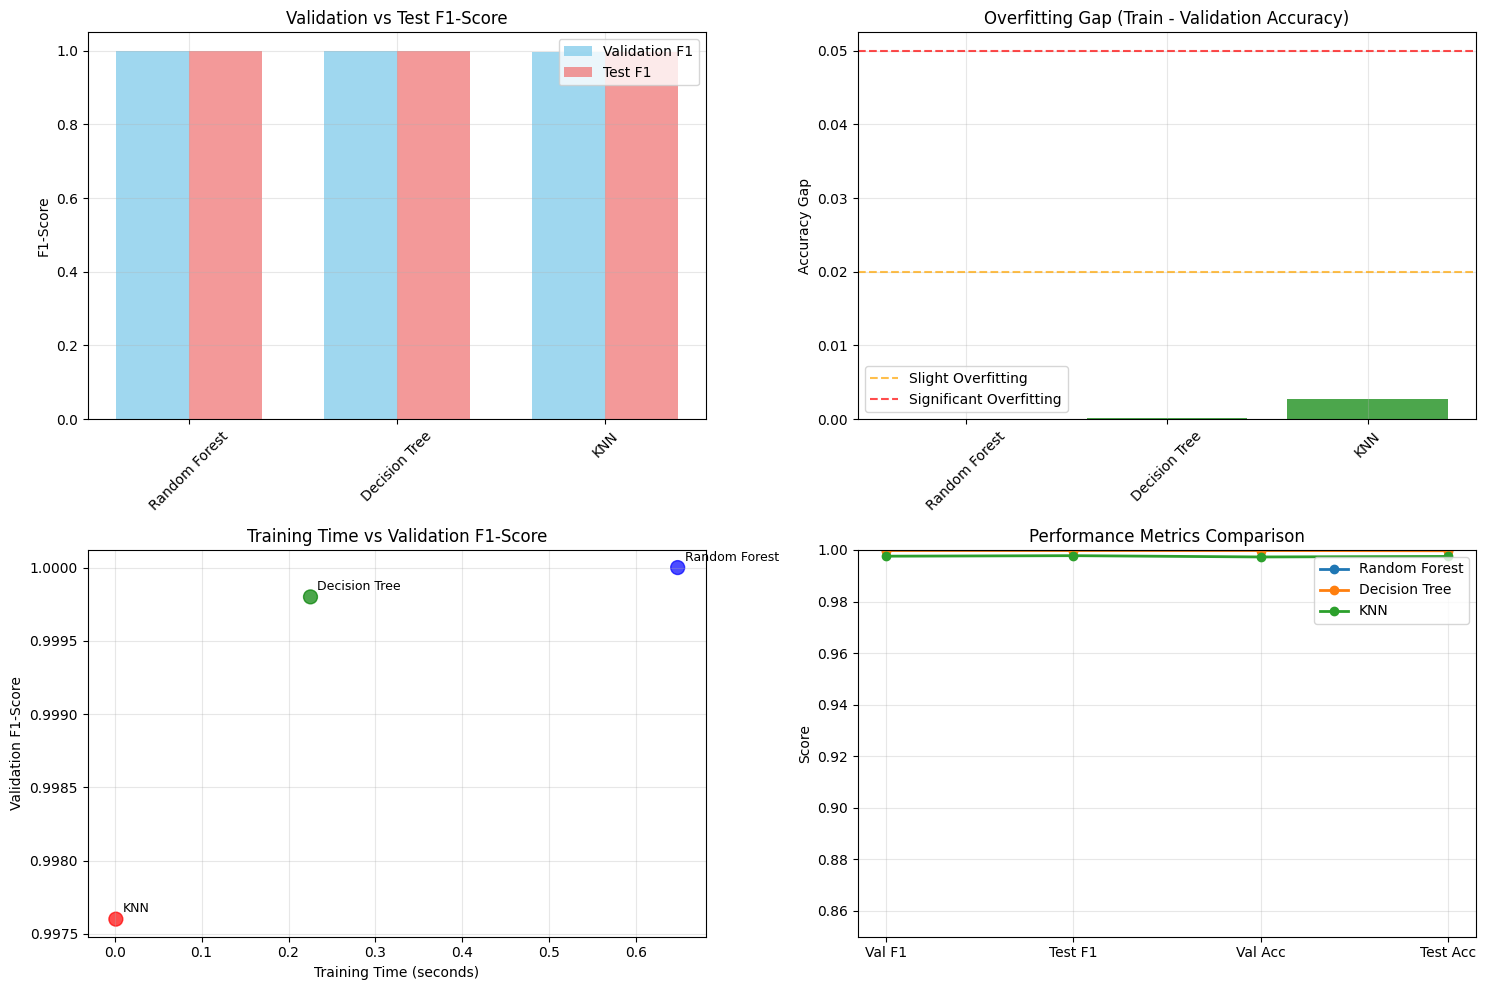

In [62]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

models = results_df.index
val_f1 = results_df['val_f1']
test_f1 = results_df['test_f1']

x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, val_f1, width, label='Validation F1', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, test_f1, width, label='Test F1', alpha=0.8, color='lightcoral')
ax1.set_title('Validation vs Test F1-Score')
ax1.set_ylabel('F1-Score')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

overfitting_gaps = results_df['overfitting_gap']
colors = ['green' if gap < 0.02 else 'orange' if gap < 0.05 else 'red' for gap in overfitting_gaps]

ax2.bar(models, overfitting_gaps, color=colors, alpha=0.7)
ax2.axhline(y=0.02, color='orange', linestyle='--', alpha=0.7, label='Slight Overfitting')
ax2.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Significant Overfitting')
ax2.set_title('Overfitting Gap (Train - Validation Accuracy)')
ax2.set_ylabel('Accuracy Gap')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

training_times = results_df['training_time']
val_f1_scores = results_df['val_f1']

colors = ['blue', 'green', 'red'][:len(models)]
ax3.scatter(training_times, val_f1_scores, s=100, alpha=0.7, c=colors)
for i, model in enumerate(models):
    ax3.annotate(model, (training_times[i], val_f1_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax3.set_title('Training Time vs Validation F1-Score')
ax3.set_xlabel('Training Time (seconds)')
ax3.set_ylabel('Validation F1-Score')
ax3.grid(True, alpha=0.3)

# 4. Model Comparison Radar-like Plot
metrics = ['val_f1', 'test_f1', 'val_acc', 'test_acc']
metric_names = ['Val F1', 'Test F1', 'Val Acc', 'Test Acc']

ax4.set_title('Performance Metrics Comparison')
for i, model in enumerate(models):
    values = [results_df.loc[model, metric] for metric in metrics]
    ax4.plot(metric_names, values, marker='o', label=model, linewidth=2, markersize=6)

ax4.set_ylabel('Score')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0.85, 1.0)  # Focus on the relevant range

plt.tight_layout()
plt.show()